# Teste do modelo usando imagens radiográficas

## Importando as bibliotecas

- OS: biblioteca para interação com sistema operacional
- SYS: biblioteca focada na interação com o interpretador do python
- TensorFlow: biblioteca para processamento de dados e contrução de CNN
- Keras: API de deep learining de alto nível executada sobre o TensorFlow
- Numpy: biblioteca para computação científica com arrays e matrizes multidimensionais
- SciKit Learn: biblioteca para ML com ferramentas para análise preditiva de dados 
- JSON: biblioteca para codificação e decodificação de no formatpo JavaScript Object Notation

In [1]:
import os
import sys
import tensorflow as tf
import keras
import numpy as np
import sklearn
import json

## Definindo a localização dos dados

Verifica se o código está sendo rodado no Google Colab e, se sim, monta o drive no ambiente de execução e aponta a pasta raiz do projeto

In [2]:
if "google.colab" in sys.modules:
    from google.colab import drive

    drive.mount("/content/drive")
    BASE_PATH = "/content/drive/MyDrive/classification-of-medical-images-using-cnn/"
else:
    BASE_PATH = os.path.abspath(os.path.join(os.getcwd(), ".."))

Mounted at /content/drive


- Armazena o local onde os dados de teste estão presentes
- Armazena o local onde o modelo já treinado está salvo
- Armazena o local onde as métricas apuradas pelo teste ficarão salvas

In [3]:
TEST_DIR = os.path.join(BASE_PATH, "data", "test")
MODEL_PATH = os.path.join(BASE_PATH, "models", "xray_images.keras")
METRICS_PATH = os.path.join(BASE_PATH, "results", "metrics.json")

os.makedirs(os.path.dirname(METRICS_PATH), exist_ok=True)

## Carregamento do dataset

- Carrega as imagens de teste:
  - `image_size`: redimensiona as imagens
  - `batch_size`: define o número de imagens por lote
  - `label_mode`: separa todas as imagens em duas classes
  - `shuffle`: define que as imagens não serão embaralhadas

- Em seguida aplica normalização dos pixels e otimiza o desemepnho usando AUTOTUNE

In [4]:
test_data = keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=(224, 224),
    batch_size=32,
    label_mode="binary",
    shuffle=False,
)

normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)

test_data = test_data.map(lambda x, y: (normalization_layer(x), y))

test_data = test_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 624 files belonging to 2 classes.


## Teste do modelo

- Carrega o modelo do disco
- Realiza o teste do modelo e salva as métricas do teste

In [5]:
model = keras.models.load_model(MODEL_PATH)

metrics = model.evaluate(test_data, return_dict=True)

20/20 ━━━━━━━━━━━━━━━━━━━━ 216s 10s/step - accuracy: 0.7980 - loss: 0.4899


## Coleta das Previsões do Modelo

- O loop `for` percorre todo o conjunto de teste em lotes (batches)
  - A função `predict` colhe o palpite do modelo em relação às imagens com um número variando de 0 a 1 que quanto mais próximo de 0, mais o modelo acredita se tratar da classe 0, quanto mais próximo 1, da classe 1
  - Armazena as classes das imagens (0 ou 1) em `y_true`, transformando os tensores em arrays
  - Armazena os palpites do modelo em `y_scores` 
  - A função `flatten` é usada para transformar matrizes multidimensionais em arrays unidimensionais
- A função `np.array` transforma os dados em arrays do numpy
- `y_pred` usa os palpites do modelo para definir as classes 0 ou 1:
  - Se o palpite for maior que `0.5`, vira 1
  - Se for menor ou igual a `0.5`, vira 0

In [6]:
y_true = []
y_scores = []

for images, labels in test_data:
    predictions = model.predict(images)
    y_true.extend(labels.numpy().flatten())
    y_scores.extend(predictions.flatten())

y_true = np.array(y_true)
y_scores = np.array(y_scores)

y_pred = (y_scores > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


## Cálculo de métricas que dependem do "nível de confiança" do modelo

- Estas métricas dependem das probabilidades atribuídas pelo modelo (`y_scores`) entre as classes binárias, i.e., quão próximo de uma decisão ele está


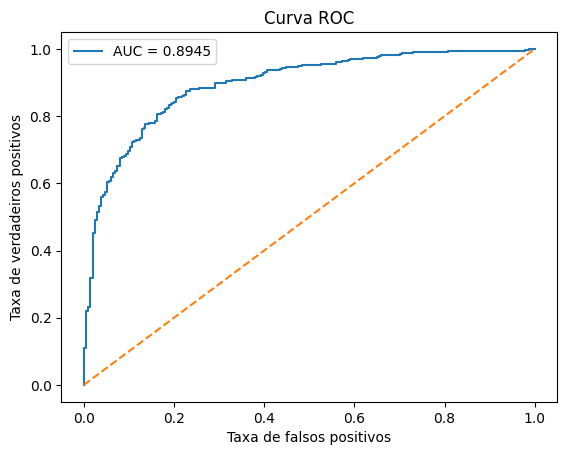

In [7]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true, y_scores)
roc_auc = sklearn.metrics.roc_auc_score(y_true, y_scores)

metrics["roc_auc"] = float(roc_auc)

metrics["roc_curve"] = {
    "fpr": fpr.tolist(),
    "tpr": tpr.tolist(),
}

import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("Taxa de falsos positivos")
plt.ylabel("Taxa de verdadeiros positivos")
plt.title("Curva ROC")
plt.legend()
plt.show()

## Cálculo de métricas que dependem da "decisão" do modelo

- Estas métricas dependem das decisões do modelo (`y_pred`) entre uma das classes binárias, i.e., qual classe o modelo previu

- A matriz de consusão é calculada pela biblioteca do SciKit e a partir dela são revelados os seguintes dados:
  - Verdadeiros Negativos (TN): quantos casos negativos (classe 0) o modelo previu corretamente
  - Falsos Positivos (FP): quantos casos negativos o modelo previu de forma errada
  - Falsos Negativos (FN): quantos casos positivos (classe 1) o modelo previu de forma errada
  - Verdadeiros Positivos (TP): quantos casos positivos o modelo previu corretamente

In [8]:
confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)

TN, FP, FN, TP = confusion_matrix.ravel().tolist()

metrics["confusion_matrix"] = {
    "TN": int(TN),
    "FP": int(FP),
    "FN": int(FN),
    "TP": int(TP),
}

- A "precision" mede: do total de previsões positivas (classe 1) quantas realmente eram positivas

  $$ \frac{Verdadeiros \, Positivos}{Verdadeiros \, Positivos + Falsos \, Positivos} $$

- A "sensibility" ou "recall" mede: do total de casos positivos, quantos o modelo conseguiu identificar corretamente

  $$ \frac{Verdadeiros \, Positivos}{Verdadeiros \, Positivos + Falsos \, Negativos} $$

- A "specificity" mede: do total de casos negativos (classe 0), quantos o modelo conseguiu identificar corretamente

  $$ \frac{Verdadeiros \, Negativos}{Verdadeiros \, Negativos + Falsos \, Positivos} $$

- O score F1 é basicamente a média harmônica entre a precisão e a sensibilidade, que acaba privilegiando o valor mais baixo entre elas

In [9]:
metrics["precision"] =  TP / (TP + FP) if (TP + FP) else 0
metrics["sensibility"] = TP / (TP + FN)
metrics["specificity"] = TN / (TN + FP)
metrics["f1_score"] = sklearn.metrics.f1_score(y_true, y_pred)

## Salvamento das métricas de avaliação

Salva as métricas de avaliação em disco no formato JSON

In [ ]:
with open(METRICS_PATH, "w") as f:
    json.dump(metrics, f, indent=4)

print(json.dumps(metrics, indent=4))

{
    "accuracy": 0.8365384340286255,
    "loss": 0.3980502486228943,
    "roc_auc": 0.8944992329607715,
    "roc_curve": {
        "fpr": [
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.004273504273504274,
            0.004273504273504274,
            0.004273504273504274,
            0.004273504273504274,
            0.008547008547008548,
            0.008547008547008548,
            0.01282051282051282,
            0.01282051282051282,
            0.021367521367521368,
            0.021367521367521368,
            0.021367521367521368,
            0.021367521367521368,
            0.02564102564102564,
            0.02564102564102564,
            0.029914529914529916,
            0.029914529914529916,
            0.03418803418803419,
            0.03418803418803419,
            0.038461538461538464,
            0.038461538461538464,
            0.042735042735042736,
            0.042735042735042736,
            0.04700854700854701,